In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
from car_part import CarPartDataset, CarPartConfig, prepare_datasets
from pathlib import Path
import colorsys
import random
import numpy as np
import maskrcnn.model as modellib
from maskrcnn.model import log
from maskrcnn import visualize
import scipy.io as sio
import json

import matplotlib.pyplot as plt
import imageio
from pycocotools.coco import COCO

In [4]:
part_annotation_path = Path('./dataset/cogito/cogito_output_batch_1_to_5.json')
images_path = Path('./dataset/cogito/')

In [5]:
ds = COCO(part_annotation_path)

loading annotations into memory...
Done (t=4.53s)
creating index...
index created!


In [6]:
num_categorie = len(ds.cats)
num_immagini = len(ds.imgs)
print(f'Number of segment categories: {num_categorie}')
print(f'Number of images: {num_immagini}')

Number of segment categories: 52
Number of images: 7496


### Number of images for each category

In [7]:
annotations_count = [(ds.cats[cat_id]['name'],len(images)) for cat_id, images in ds.catToImgs.items()]
damages_list = ['scratch', 'dent', 'severe-dent', 'substitution', 'severe_dent']
cats_count = list(filter(lambda x: x[0] not in damages_list, annotations_count))
cats_count = sorted(cats_count, key=lambda x: x[1], reverse=True)
for k in cats_count:
    print('{:<40s}{:>5}'.format(k[0], k[1]))

roof                                     3872
radiator-grill                           3762
bumper_back                              3432
bumper_front                             3362
headlight_right                          3328
door-pillar_left                         3248
door_front_right                         3227
door-window_rear_left                    3173
door-window_front_right                  3058
wheels_front_right                       2932
hood                                     2819
fender_front_left                        2751
door_front_left                          2711
fender_back_right                        2701
wheels_back_left                         2701
door-sill_right                          2684
mirror_left                              2679
wheels_back_right                        2644
fender_back_left                         2596
wheels_front_left                        2567
door-sill_left                           2533
door-window_rear_right            

## Use the class BalanceDataset to balance the categories of segments contained in training, validation and test images

#### Class BalanceDataset needs the following arguments:

In [8]:
# dictionary to obtain annotations contained in every image
imgToAnns = ds.imgToAnns
# all images Id
all_images_ids = ds.getImgIds()
# dictionary to obtain images containing such segment category
catToImgs = ds.catToImgs

In [9]:
from balancedataset import BalanceDataset

balancer = BalanceDataset(imgToAnns, all_images_ids, catToImgs)
# set the fraction for the three sets: training, validation, test
balancer.set_percentages(train_percentage=0.7, val_percentage=0.1, test_percentage=0.2)

In [10]:
img_id_train, img_id_val, img_id_test = balancer.split_balanced()

Immagini di training: 5247
Immagini di validation: 750
Immagini di test: 1499


In [21]:
categories = {k: v['name'] for k,v in ds.cats.items()}

In [26]:
balancer.verify_split(categories)

CatId                           Tot	train  %      valid  %      test   %     
back_side                       391	275   70.3   37     9.5    79     20.2  
back-side                      1705	1175  68.9   175    10.3   355    20.8  
back-window                    2370	1664  70.2   238    10.0   468    19.7  
bumper_back                    3432	2416  70.4   348    10.1   668    19.5  
bumper_front                   3362	2359  70.2   346    10.3   657    19.5  
dent                            724	521   72.0   69     9.5    134    18.5  
Dent                           1917	1345  70.2   174    9.1    398    20.8  
door_front_left                2711	1897  70.0   290    10.7   524    19.3  
door_front_right               3227	2243  69.5   333    10.3   651    20.2  
door-pillar_left               3248	2273  70.0   341    10.5   634    19.5  
door-pillar_right              2393	1681  70.2   232    9.7    480    20.1  
door_rear_left                 2222	1559  70.2   239    10.8   424    19.1 

### Look into images in training set

In [27]:
dataset_train = CarPartDataset()
id_to_category = dataset_train.load_dataset(part_annotation_path, images_path, img_id_train)
dataset_train.prepare()

num_img_not_it_annotations 6
[4815, 5787, 6234, 6485, 6813, 7331]
Images loaded: 5247


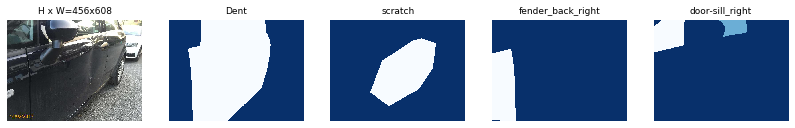

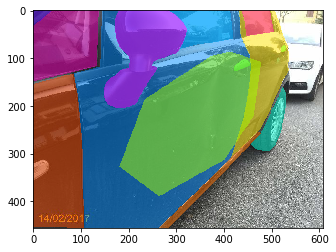

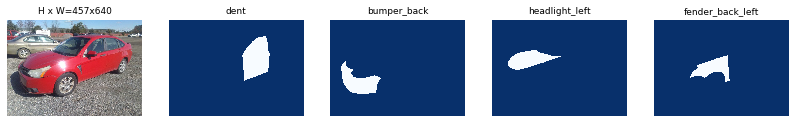

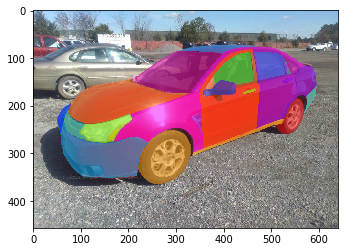

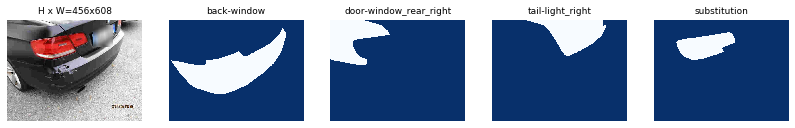

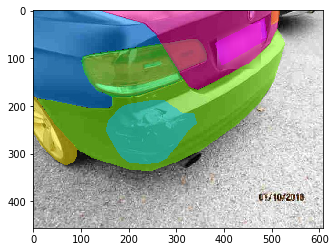

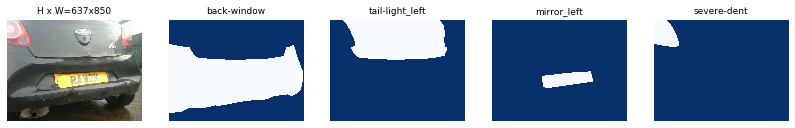

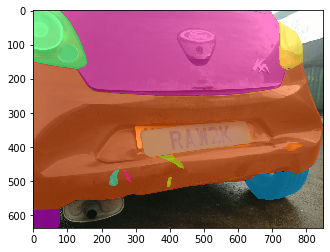

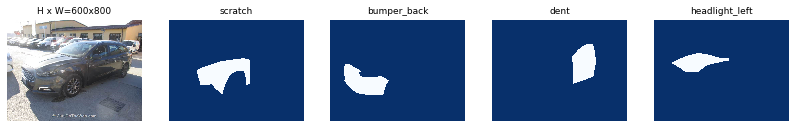

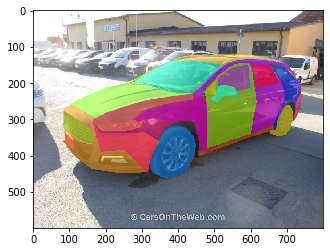

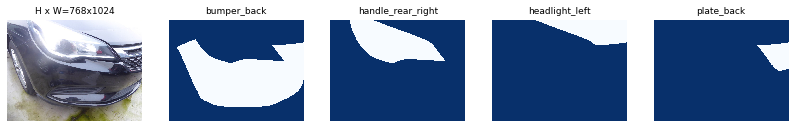

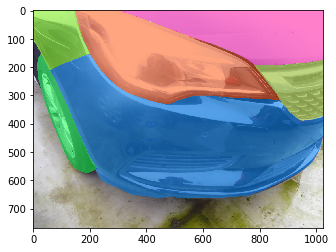

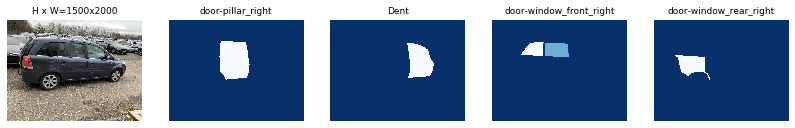

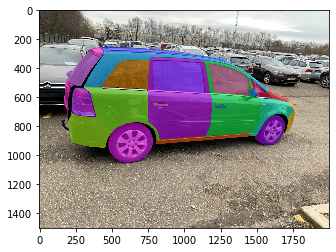

In [28]:
colors = visualize.generate_colormap(40, scaled=False)
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 7)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, id_to_category, limit=6)
    img_copy = image.copy()
    for l in range(mask.shape[-1]):
        img_copy = visualize.apply_mask(img_copy, mask[:,:,l], colors[l])
    plt.imshow(img_copy)

In [ ]:

dataset_val = CarPartDataset()
dataset_val.load_dataset(part_annotation_path, images_path, img_id_val)
dataset_val.prepare()

dataset_test = CarPartDataset()
dataset_test.load_dataset(part_annotation_path, images_path, img_id_test)
dataset_test.prepare()